In [13]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
a=[]

In [14]:
def dnorm(x,sd):
    return 1 / (np.sqrt(2 * np.pi) * sd) * np.e ** (-np.power((x) / sd, 2) / 2)

def gaussian_kernel(size, sigma=1, verbose=False):
    kernel_1D = np.linspace(-(size // 2), size // 2, size)
    # print(kernel_1D)

    for i in range(size):
        kernel_1D[i] = dnorm(kernel_1D[i], sigma)


    kernel_2D = np.outer(kernel_1D.T, kernel_1D.T)
    kernel_2D *= 1.0 / kernel_2D.max()


    return kernel_2D

In [15]:
def dnorm2(x,sd):
    return -x / (np.sqrt(2 * np.pi) * sd**3) * np.e ** (-np.power((x) / sd, 2) / 2)
    
def gd_kernel(size, sigma=1):
    kernel_1D = np.linspace(-(size // 2), size // 2, size)
    for i in range(size):
        kernel_1D[i] = dnorm2(kernel_1D[i], sigma)
    


    kernel_2D = np.outer(kernel_1D.T, kernel_1D.T)
    kernel_2D *= 1.0 / kernel_2D.max()


    return kernel_2D

In [16]:
def convolution(image, kernel, average=False, verbose=False):
    global a
    if len(image.shape) == 3:
        print("3 colour Channels so converting to greyscale : {}".format(image.shape))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    image_row, image_col = image.shape
    kernel_row, kernel_col = kernel.shape

    output = np.zeros(image.shape)
    outputx = np.zeros(image.shape)
    outputy = np.zeros(image.shape)
# Padding image
    pad_height = int((kernel_row - 1) / 2)
    pad_width = int((kernel_col - 1) / 2)

    padded_image = np.zeros((image_row + (2 * pad_height), image_col + (2 * pad_width)))
    padded_image[pad_height:padded_image.shape[0] - pad_height, pad_width:padded_image.shape[1] - pad_width] = image
# double loop and going over each pixel and convouting with the kernel
    for row in range(image_row):
        for col in range(image_col):
            output[row, col] = np.sum(kernel * padded_image[row:row + kernel_row, col:col + kernel_col])
            outputx[row, col] = np.sum(kernel * padded_image[row:row + kernel_row,col])
            outputy[row, col] = np.sum(kernel * padded_image[row,col:col + kernel_col])
            if average:
                output[row, col] /= kernel.shape[0] * kernel.shape[1]
                outputx[row, col] /= kernel.shape[0] * kernel.shape[1]
                outputy[row, col] /= kernel.shape[0] * kernel.shape[1]
    
    if verbose:
        a.append(outputx)
        a.append(outputy)
    # kernel=np.flip(kernel,axis=0)
    # for row in range(image_row):
    #     for col in range(image_col):
    #         outputy[row, col] = np.sum(kernel * padded_image[row:row + kernel_row, col:col + kernel_col])
                
                       


    return output

In [17]:
def gaussian_blur(image, kernel_size,sigma=1, verbose=False):
    kernel = gaussian_kernel(kernel_size, sigma, verbose=verbose)
    print("Kernel Shape : {}".format(kernel.shape))

    return convolution(image, kernel, average=True, verbose=verbose)


In [18]:
# kernel_size=5
# sigma=2
# kernel_1D = np.linspace(-(kernel_size // 2), kernel_size // 2, kernel_size)
# for i in range(kernel_size):
#     kernel_1D[i] = dnorm2(kernel_1D[i], sigma)

# kernel_2Dgx = np.outer(kernel_1D.T, kernel_1D.T)
# kernel_2Dgx *= 1.0 / kernel_2Dgx.max()


In [19]:
#Convolution with First derivative of gaussian in x and y directions
def derivative(image):
    gx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    gy=np.flip(gx.T, axis=0)
    Ix1= convolution(image, gx, verbose=False)
    Iy1= convolution(image, gy, verbose=False)

    return Ix1,Iy1


In [20]:
def gradient_madnitude(Ix1,Iy1):
# M(x,y) = sqrt(I′x(x,y)^2 + I′y(x,y)^2)                            gradient madnitude
    Magnitude = np.sqrt(np.square(Ix1) + np.square(Iy1))
    Magnitude *= 255.0 / Magnitude.max()

    theta = np.arctan2(Iy1, Ix1)            #gradient orientation
    return Magnitude,theta

In [21]:
def nms(image, angles):
#perform non maxima supression by comparing pixel values with nearby pixels in the same direction
    m,n = image.shape
    suppressed = np.zeros((m,n))
    for i in range(1, m - 1):
        for j in range(1, n- 1):
            if (0 <= angles[i, j] < 22.5) or (157.5 <= angles[i, j] <= 180):
                temp_pixel = max(image[i, j - 1], image[i, j + 1])
            elif (22.5 <= angles[i, j] < 67.5):
                temp_pixel = max(image[i - 1, j - 1], image[i + 1, j + 1])
            elif (67.5 <= angles[i, j] < 112.5):
                temp_pixel = max(image[i - 1, j], image[i + 1, j])
            else:
                temp_pixel = max(image[i + 1, j - 1], image[i - 1, j + 1])
            
            if image[i, j] >= temp_pixel:
                suppressed[i, j] = image[i, j]

    # plt.imshow(suppressed,cmap='gray')
    # plt.title("Non maximum supression")

    # plt.show()
    return suppressed


In [22]:
def hysteresis(supressed,highThreshold=0.15,lowThreshold=0.05):
# Set high and low threshold

    highThreshold = supressed.max() * 0.3
    lowThreshold = highThreshold * 0.07
    M, N = supressed.shape
    out = np.zeros((M,N), dtype= np.uint8)

    # If edge intensity is greater than 'High' it is a sure-edge
    # below 'low' threshold, it is a sure non-edge
    strong_i, strong_j = np.where(supressed >= highThreshold)
    zeros_i, zeros_j = np.where(supressed < lowThreshold)

    # weak edges
    weak_i, weak_j = np.where((supressed <= highThreshold) & (supressed >= lowThreshold))

    # Set same intensity value for all edge pixels
    out[strong_i, strong_j] = 255
    out[zeros_i, zeros_j ] = 0
    out[weak_i, weak_j] = 75

    M, N = out.shape
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (out[i,j] == 75):
                if 255 in [out[i+1, j-1],out[i+1, j],out[i+1, j+1],out[i, j-1],out[i, j+1],out[i-1, j-1],out[i-1, j],out[i-1, j+1]]:
                    out[i, j] = 255
                else:
                    out[i, j] = 0
    return out

sigma value=  1
Kernel Shape : (15, 15)
3 colour Channels so converting to greyscale : (481, 321, 3)
8


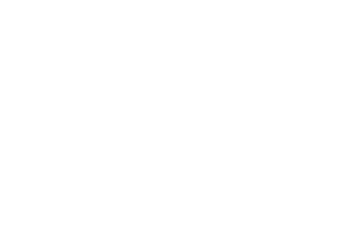

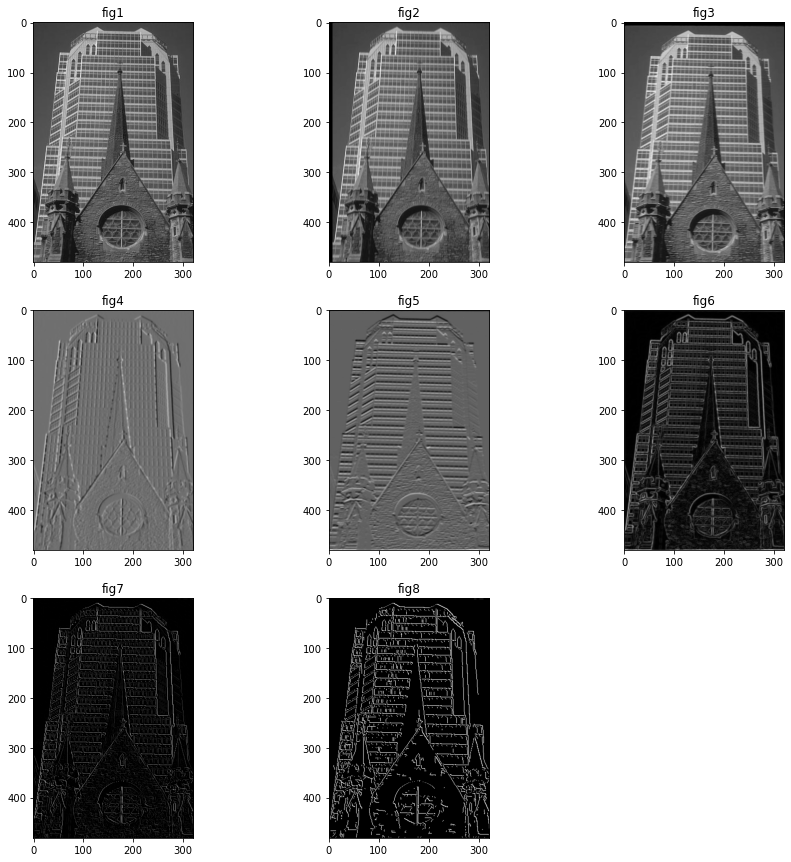

Kernel Shape : (15, 15)
3 colour Channels so converting to greyscale : (481, 321, 3)
8


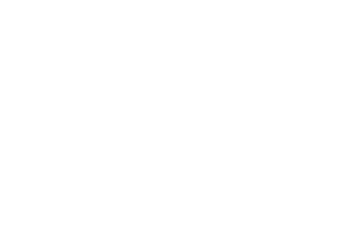

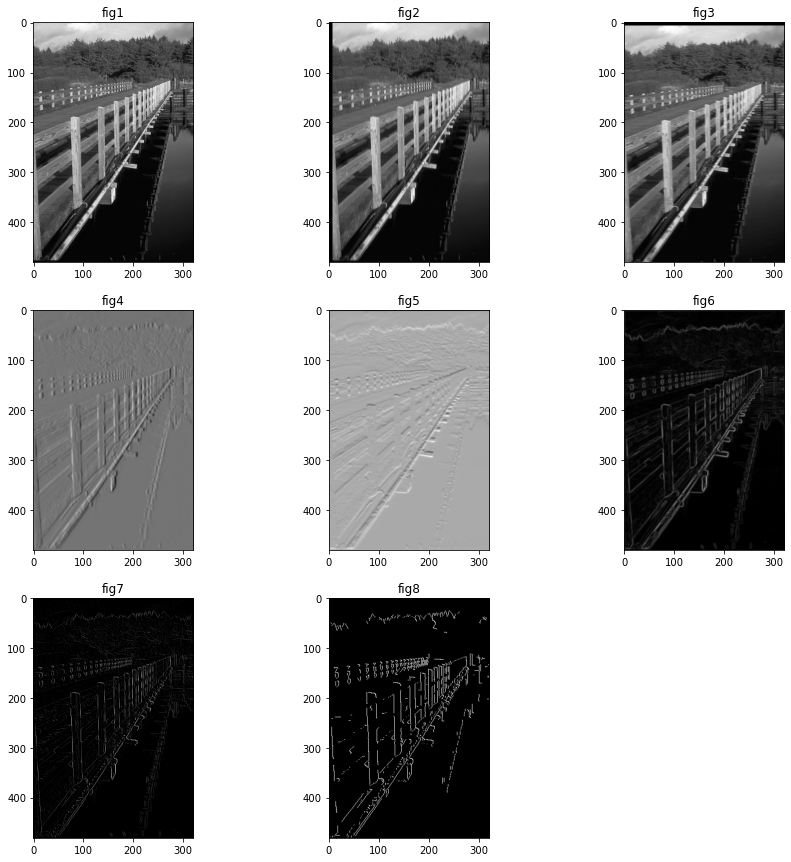

Kernel Shape : (15, 15)
3 colour Channels so converting to greyscale : (481, 321, 3)
8


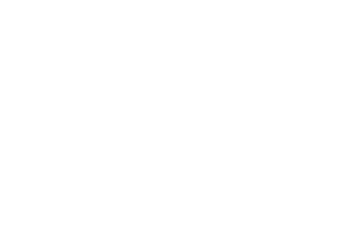

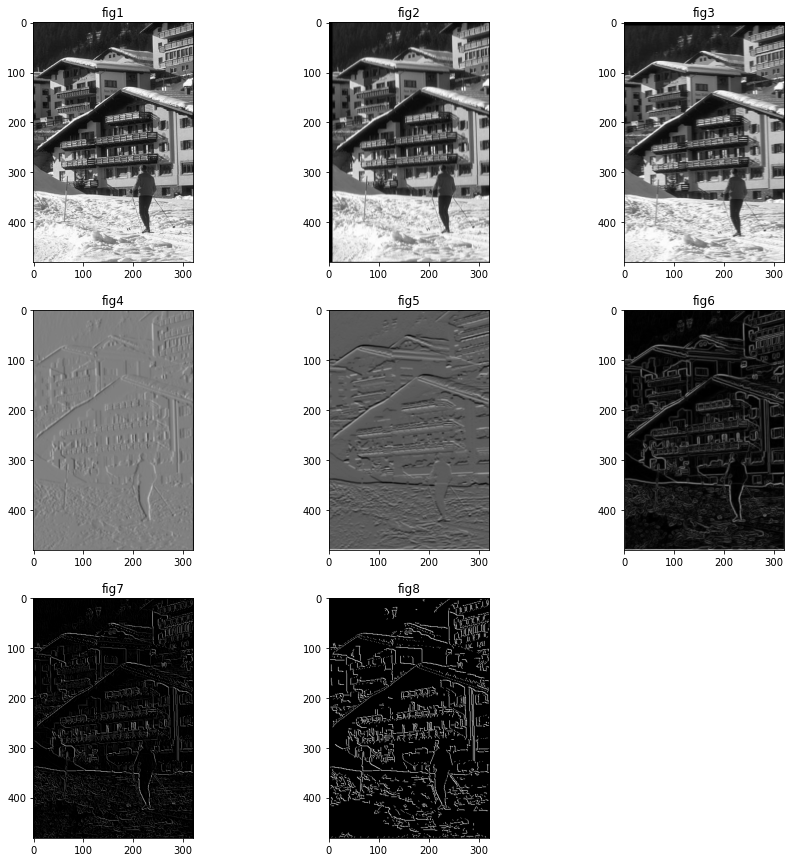

sigma value=  2
Kernel Shape : (15, 15)
3 colour Channels so converting to greyscale : (481, 321, 3)
8


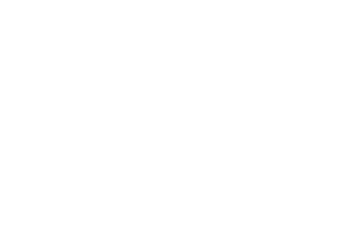

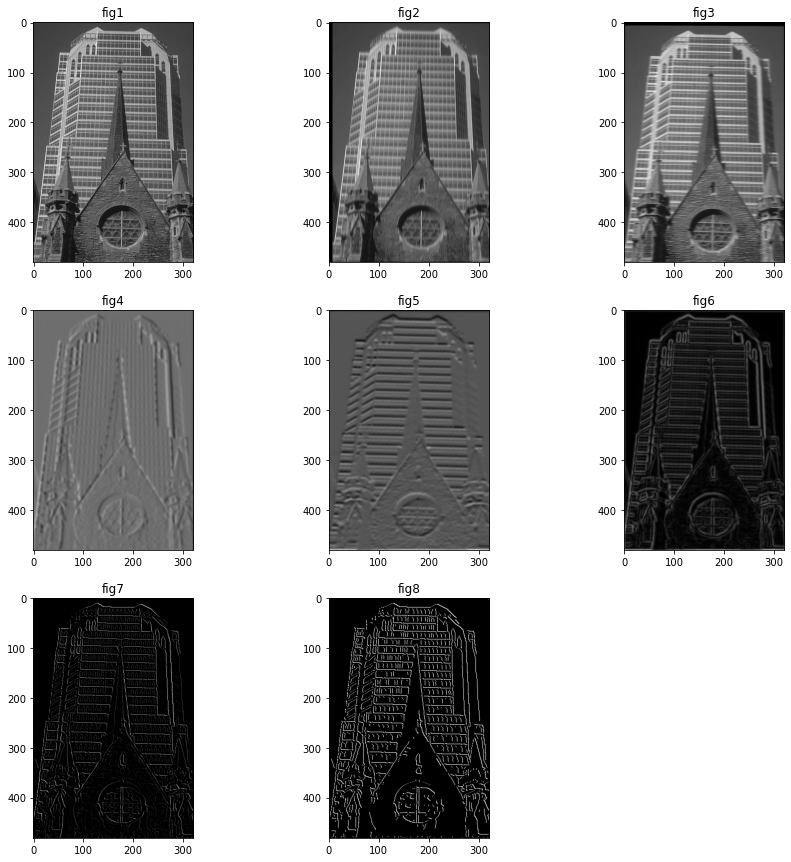

Kernel Shape : (15, 15)
3 colour Channels so converting to greyscale : (481, 321, 3)
8


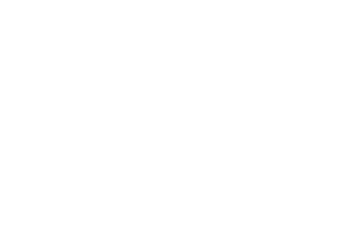

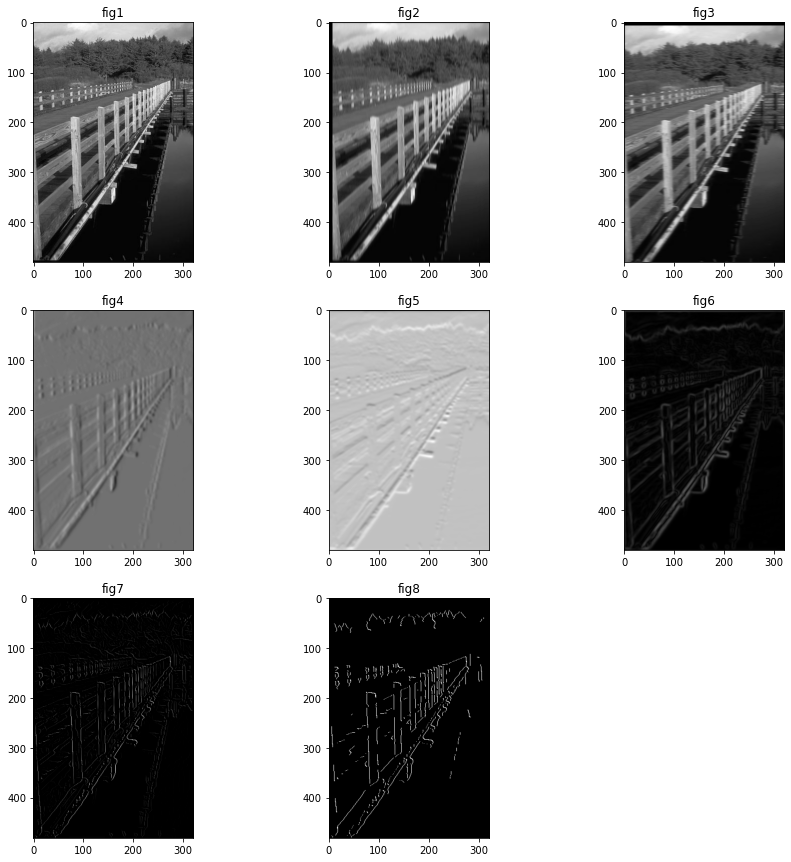

Kernel Shape : (15, 15)
3 colour Channels so converting to greyscale : (481, 321, 3)
8


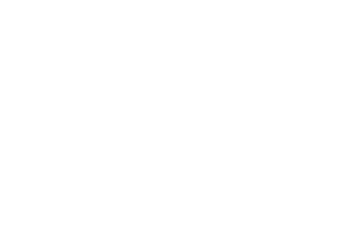

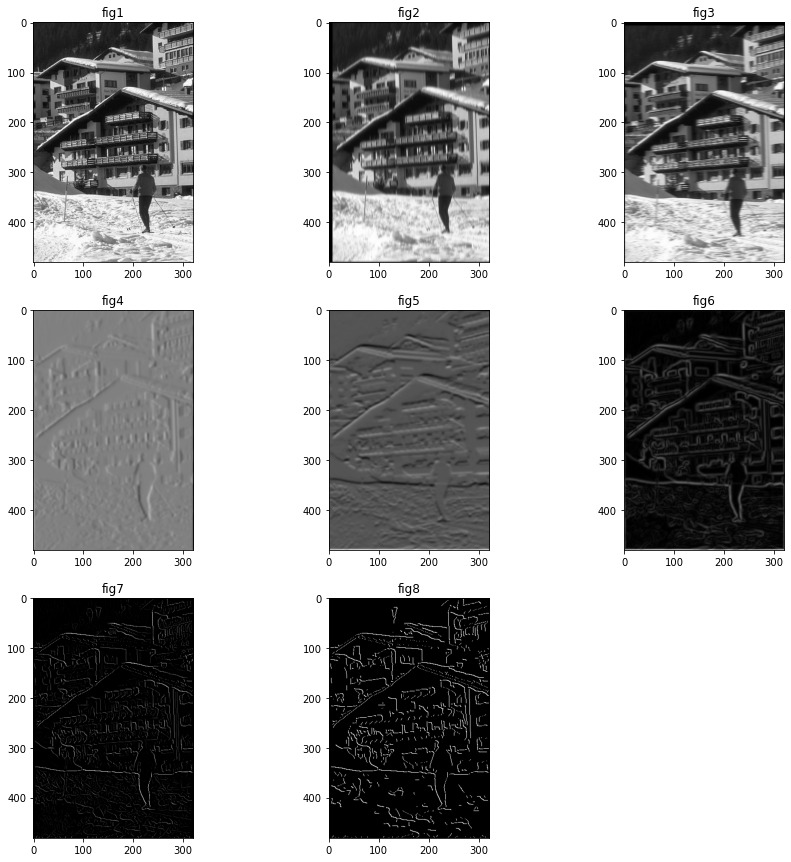

sigma value=  3
Kernel Shape : (15, 15)
3 colour Channels so converting to greyscale : (481, 321, 3)
8


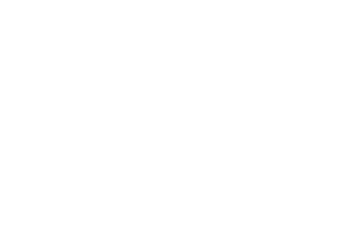

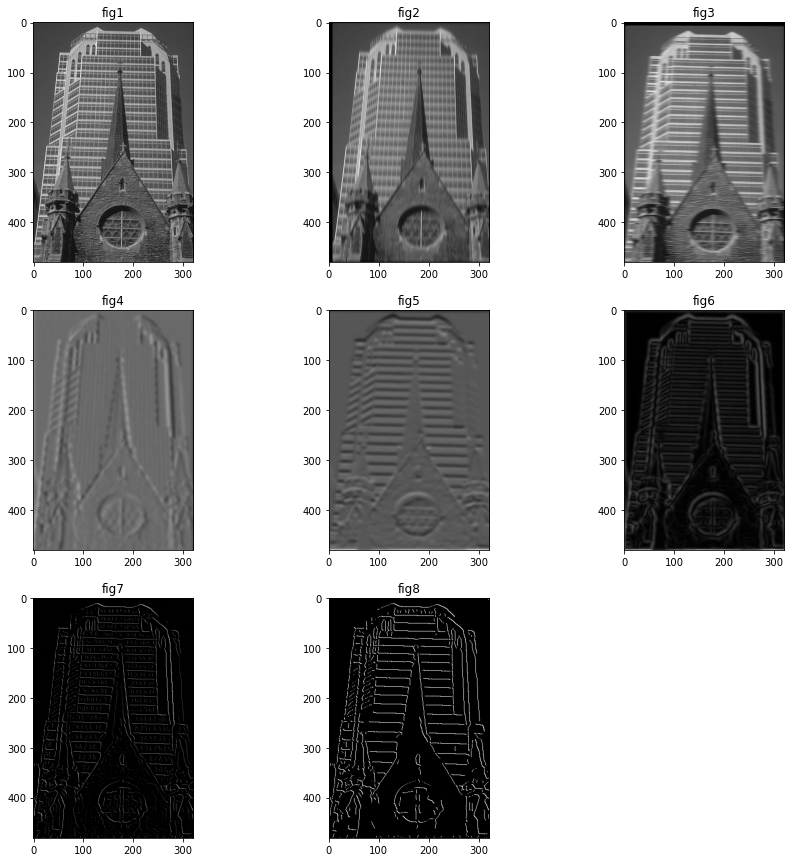

Kernel Shape : (15, 15)
3 colour Channels so converting to greyscale : (481, 321, 3)
8


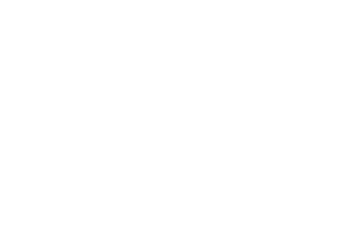

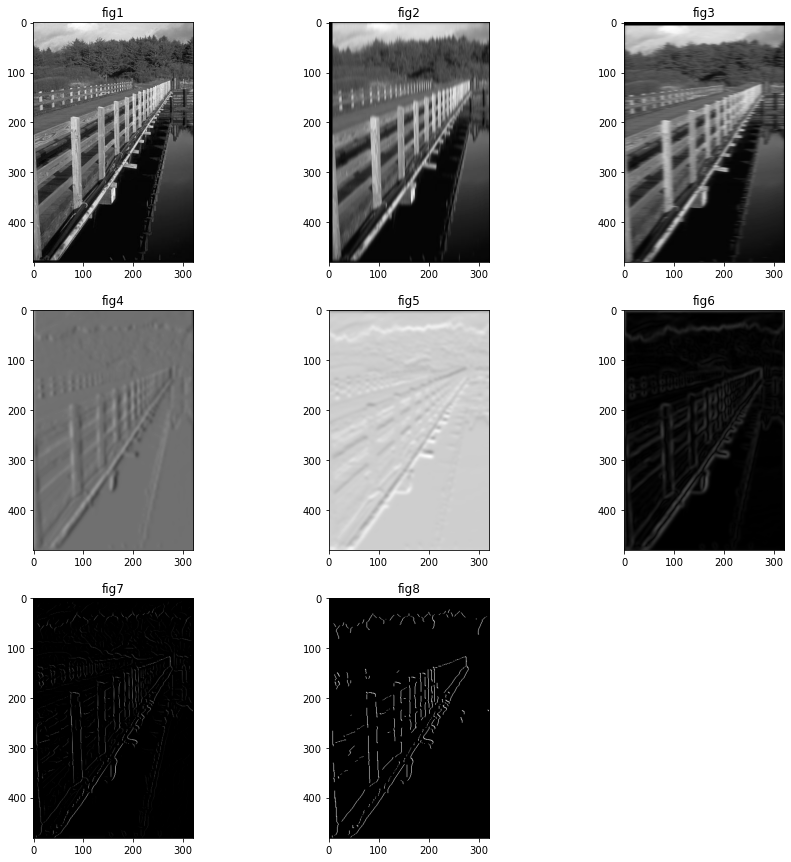

Kernel Shape : (15, 15)
3 colour Channels so converting to greyscale : (481, 321, 3)
8


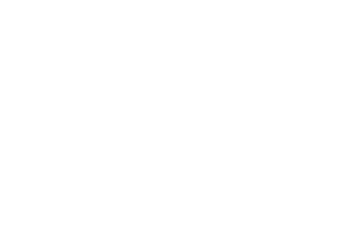

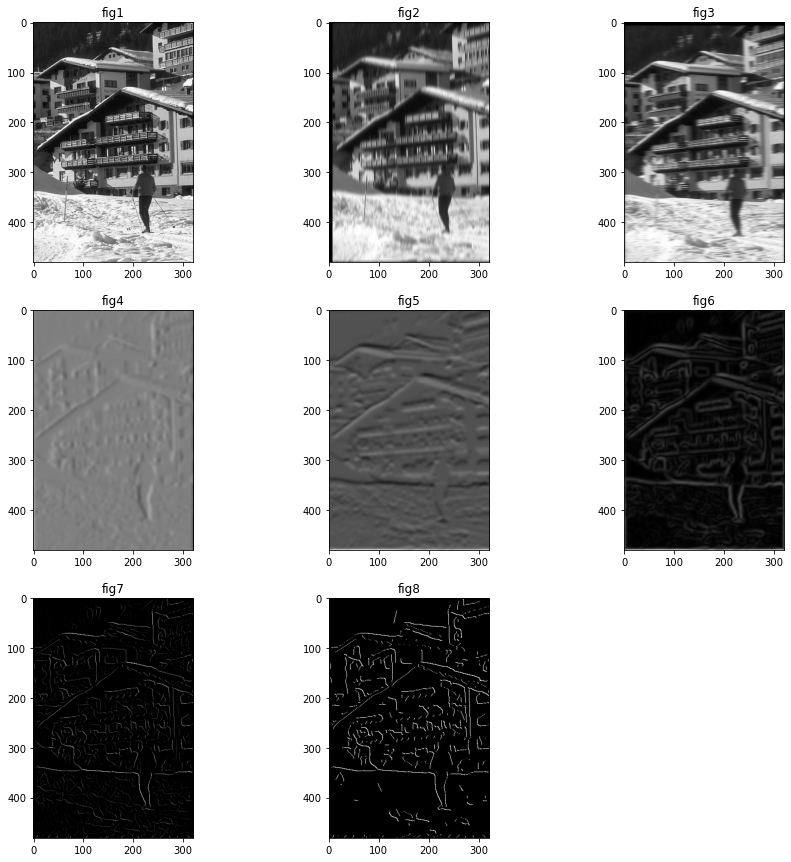

In [23]:

image_list=["img_1.jpg","img_2.jpg","img_3.jpg"]
global a
for s in range(1,4):
    print("sigma value= ",str(s))
    for x in image_list:
        
        a=[]
        image = cv2.imread(x)
        a.append(image)
        plt.axis('off')
        
        I=gaussian_blur(image,kernel_size=15,sigma=s, verbose=True)


        Ix1,Iy1=derivative(I)
        a.append(Ix1)
        a.append(Iy1)

        Magnitude,theta=gradient_madnitude(Ix1,Iy1)
        a.append(Magnitude)
        supressed=nms(Magnitude,theta)
        a.append(supressed)
        final=hysteresis(supressed)
        a.append(final)
        fig = plt.figure(figsize=(15, 15))
        print(len(a))

        count=1
        for i in range(0,len(a)):
            fig.add_subplot(3, 3, i+1)
            plt.imshow(a[i], cmap='gray')
            plt.title("fig" + str(i+1))
            count+=1
        plt.show()

